In [1]:
#importing important libraries

import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' 
        }

testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_samples = pd.read_csv(r"C:\Users\Roshan Salunke\Downloads\Data Science Course\train_sample.csv",skiprows=skiprows,nrows=nrows,dtype=dtypes,usecols=colnames)

In [3]:
len(train_samples)

100000

In [4]:
print(train_samples.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [5]:
train_samples.memory_usage().sum()/1024**2

1.812103271484375

In [6]:
train_samples.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [7]:
train_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [9]:
def fraction_unique(x):
    return len(train_samples[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_samples.columns}


number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

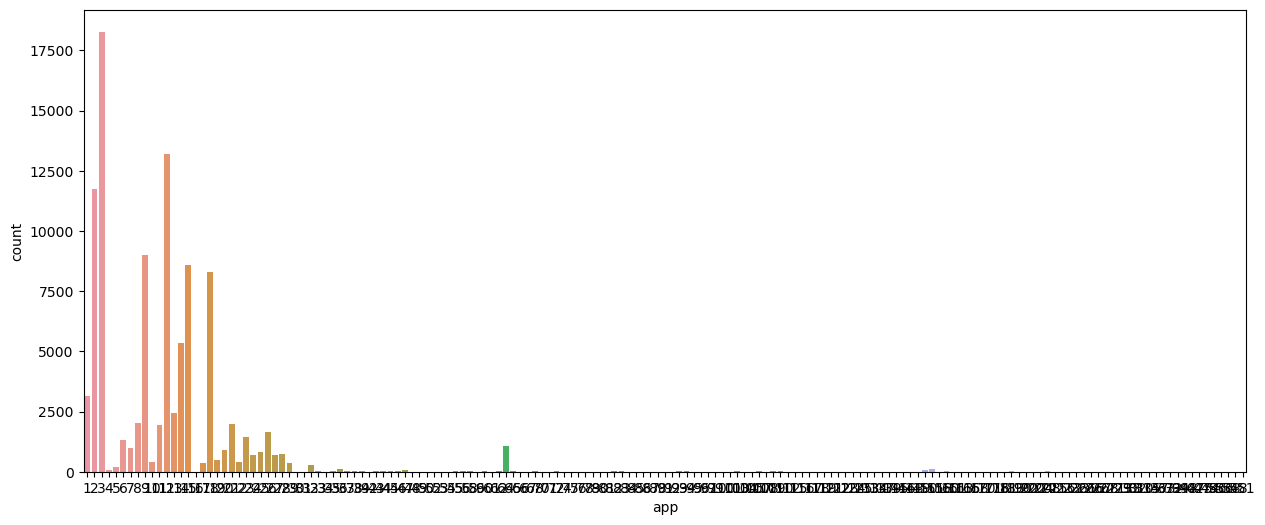

In [10]:
plt.figure(figsize=(15,6))

sns.countplot(x='app',data=train_samples)
plt.show()

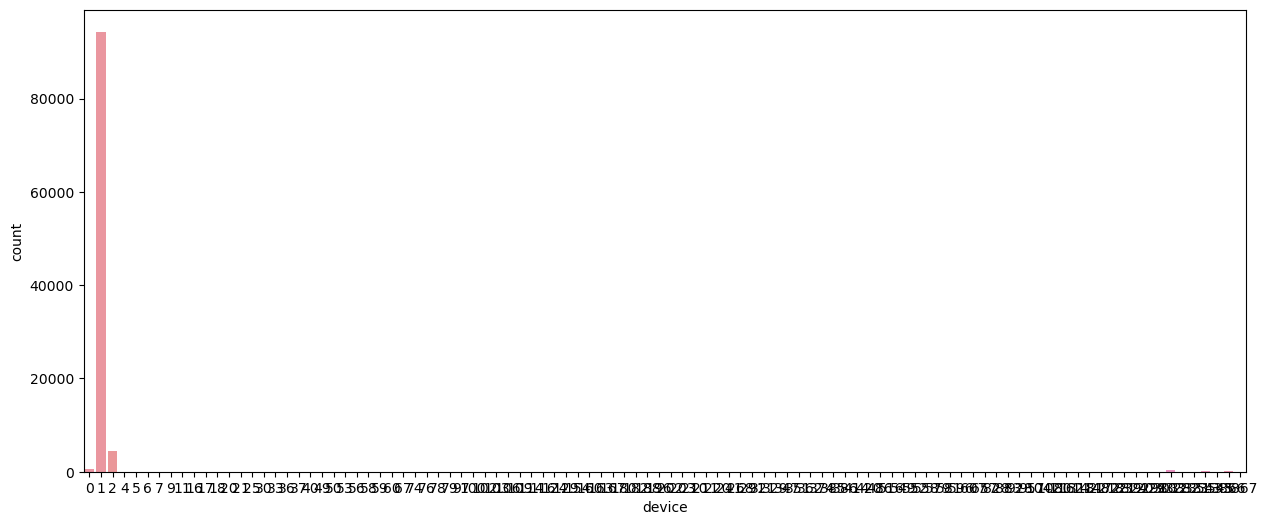

In [11]:
plt.figure(figsize=(15,6))
sns.countplot(x='device',data=train_samples)
plt.show()

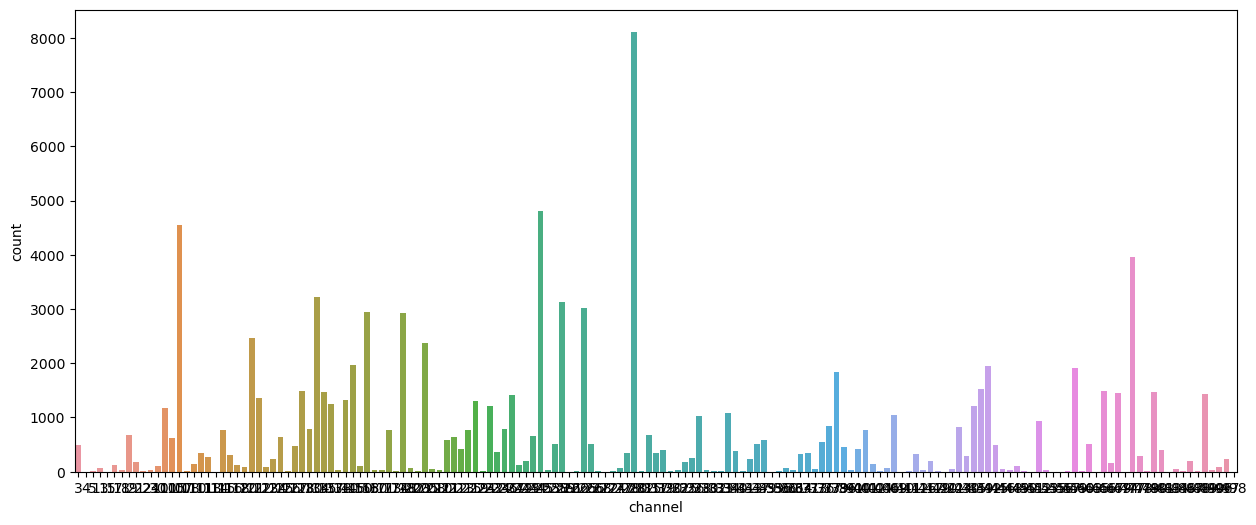

In [12]:
plt.figure(figsize=(15,6))

sns.countplot(x='channel',data=train_samples)
plt.show()

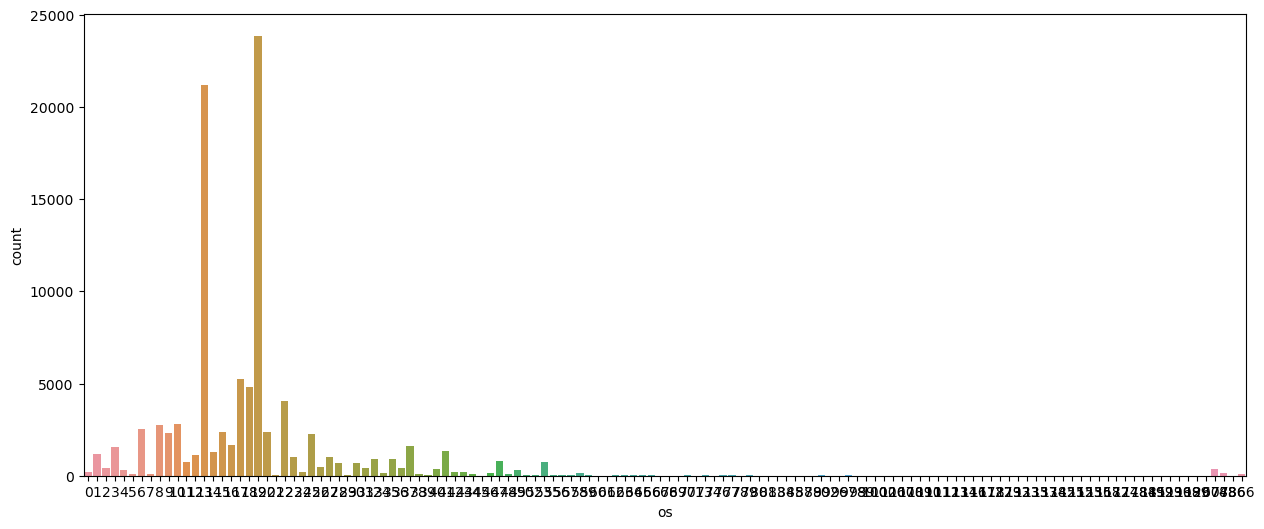

In [13]:
plt.figure(figsize=(15,6))
sns.countplot(x='os',data=train_samples)
plt.show()

In [14]:
100*(train_samples['is_attributed'].astype('object').value_counts()/len(train_samples.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

In [15]:
app_target = train_samples.groupby('app').is_attributed.agg(['mean','count'])

app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [16]:
frequent_apps = train_samples.groupby('app').size().reset_index(name='count')

frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.8)]

frequent_apps = frequent_apps.merge(train_samples,on='app',how='inner')

frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


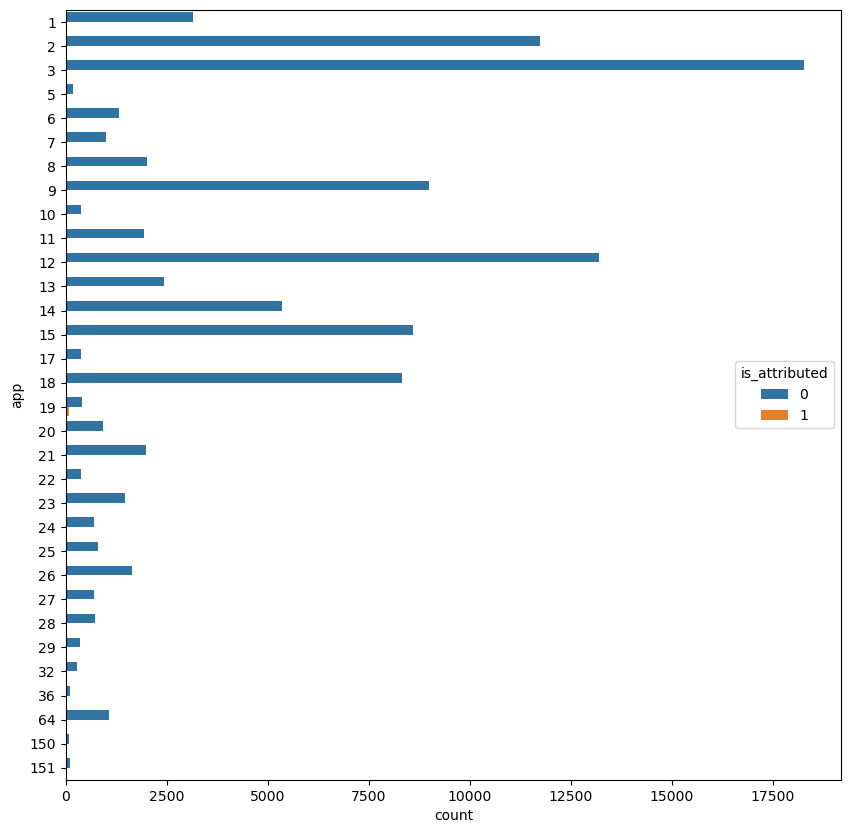

In [17]:
plt.figure(figsize=(10,10))
sns.countplot(y='app',hue='is_attributed',data=frequent_apps)
plt.show()

In [18]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    

    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    

    df["day_of_year"] = df['datetime'].dt.dayofyear
    
    

    df["month"] = df['datetime'].dt.month
    
    

    df["hour"] = df['datetime'].dt.hour
    
    
    
    return df

In [19]:
train_samples.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [20]:
train_samples = timeFeatures(train_samples)

train_samples.drop(['click_time', 'datetime'], axis=1,inplace=True)

train_samples.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [21]:
train_samples.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [22]:
train_samples.memory_usage().sum()/1024**2

4.100921630859375

In [23]:
int_vars = ['app','device','os','channel','day_of_week','month','hour','day_of_year']

train_samples[int_vars] = train_samples[int_vars].astype('uint16')

In [24]:
train_samples.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [25]:
train_samples.memory_usage().sum()/1024**2

1.812103271484375

In [26]:
ip_count = train_samples.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [27]:
'''creates groupings of IP addresses with other features and appends the new features to the df'''

def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    
    # ip_day_hour
    ip_day_hour = df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    
#   ip_hour_channel
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    
#   ip_hour_os
    ip_hour_os = df.groupby(['ip','hour','os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    
#   ip_hour_app
    ip_hour_app =df.groupby(['ip','hour','app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')

    
#   ip_hour_device
    ip_hour_device = df.groupby(['ip','hour','device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    
    '''merge the new aggregated features with the df'''
    
#   left join ip_count to df on ip
    df = pd.merge(df,ip_count,on='ip',how='left')
    
    
#   delete ip_count
    
    #df = df.drop('ip_count',axis=1)
    
    #left join ip_day_hour to df on ip, day_of_week and hour

    df = pd.merge(df,ip_day_hour,on=['ip','day_of_week', 'hour'], how='left')
    
    
    #delete ip_day_hour

   # df = df.drop('ip_day_hour', axis=1)
    
    
#   left join ip_hour_channel to df on ip, hour, channel

    df = pd.merge(df,ip_hour_channel, on=['ip','hour','channel'],how='left')
    
#   delete ip_hour_channel
  #  df = df.drop('ip_hour_channel',axis=1)
    
    
    #left join ip_hour_os to df on ip, hour and os

    df = pd.merge(df,ip_hour_os, on=['ip','hour','os'], how='left')
    
#   delete ip_hour_os
    
  #  df = df.drop('ip_hour_os',axis=1)
    
    
    #    left join ip_hour_app to df on ip, hour and app

    df = pd.merge(df,ip_hour_app,on=['ip','hour','app'],how='left')
    
    
#     delete ip_hour_app 
    
    #df = df.drop('ip_hour_app',axis=1)
    
    #left join ip_hour_device to df on ip , hour and device

    df = pd.merge(df,ip_hour_device,on=['ip','hour','device'],how='left')
    
#   delete ip_hour_device 
    #df = df.drop('ip_hour_device',axis=1)
    
    
#  return df
    return df
    

In [28]:
train_samples = grouped_features(train_samples)

In [29]:
train_samples.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [30]:
train_samples.memory_usage().sum()/1024**2

3.719329833984375

In [31]:
gc.collect()

92968

In [32]:
x = train_samples.drop('is_attributed',axis=1)
y = train_samples[['is_attributed']]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [33]:
print(y_train.mean())

print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


In [34]:
tree = DecisionTreeClassifier(max_depth=2,random_state=1)

adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm='SAMME',
    random_state=1
)

In [35]:
adaboost_model_1.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [36]:
predictions = adaboost_model_1.predict_proba(x_test)
predictions[:10]

array([[0.54049582, 0.45950418],
       [0.53588662, 0.46411338],
       [0.53885559, 0.46114441],
       [0.52427816, 0.47572184],
       [0.52018053, 0.47981947],
       [0.5308397 , 0.4691603 ],
       [0.53055748, 0.46944252],
       [0.54126954, 0.45873046],
       [0.52347347, 0.47652653],
       [0.51624249, 0.48375751]])

In [37]:
metrics.roc_auc_score(y_test,predictions[:,1])

0.9523839750549848

In [38]:
param_grid = {"base_estimator__max_depth": [2, 5],
             "n_estimators": [200, 400, 600]
             }

In [39]:
tree = DecisionTreeClassifier(random_state=1)


ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm='SAMME')


In [40]:
folds = 3

grid_search_ABC = GridSearchCV(ABC,
                               cv = folds,
                               param_grid = param_grid,
                               scoring='roc_auc',
                               return_train_score=True,
                               verbose=1)

In [41]:
grid_search_ABC.fit(x_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(random_state=1),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [42]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,15.520201,0.292709,0.576809,0.015945,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,30.932726,0.099534,1.105593,0.002620,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,45.989474,0.678191,1.703720,0.043700,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,0.000253
3,33.406433,0.313690,0.666851,0.006344,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890670,0.940373,0.938163,0.923069,0.022927,5,1.000000,1.000000,1.000000,1.000000,0.000000
4,67.150364,0.390430,1.322005,0.013910,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.894237,0.938903,0.945022,0.926054,0.022636,4,1.000000,1.000000,1.000000,1.000000,0.000000
5,102.048854,0.268316,1.943987,0.026010,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.888973,0.925932,0.934172,0.916359,0.019655,6,1.000000,1.000000,1.000000,1.000000,0.000000


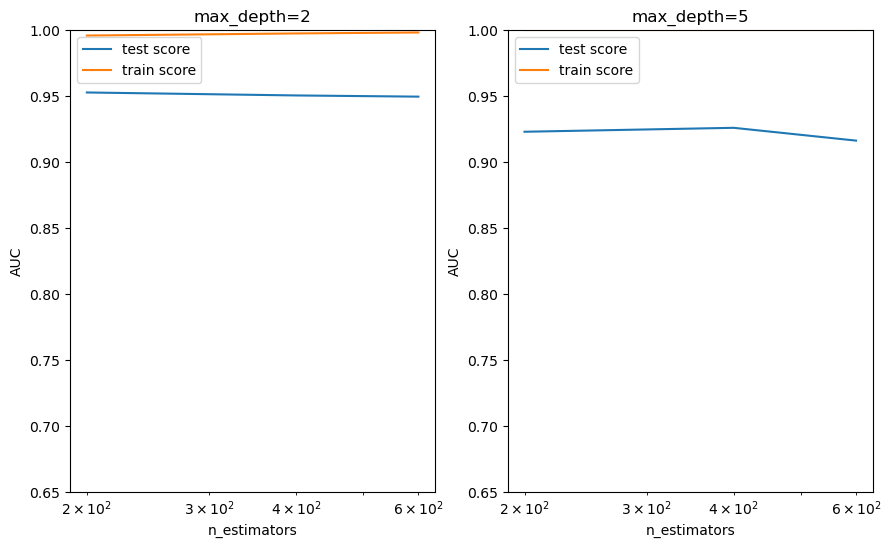

In [43]:
plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    
    plt.subplot(1,3,n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]
    
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_test_score'])
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_train_score'])
    
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title(f'max_depth={depth}')
    plt.ylim([0.65,1])
    plt.legend(['test score','train score'],loc='upper left')
    plt.xscale('log')
    

In [44]:
tree = DecisionTreeClassifier(max_depth=2,random_state=1)

ABC = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=200,
                        learning_rate=0.6,
                        algorithm='SAMME',
                        random_state=1)

ABC.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [45]:
predictions = ABC.predict_proba(x_test)
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [46]:
metrics.roc_auc_score(y_test,predictions[:,1])

0.960727748545338

In [47]:
param_grid ={'learning_rate': [0.2,0.6,0.9],
             'subsample': [0.3,0.6,0.9]
}

In [48]:
GBC = GradientBoostingClassifier(max_depth=2,n_estimators=200,random_state=1)

In [49]:
folds = 3

grid_search_GBC = GridSearchCV(GBC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              return_train_score=True,
                              verbose=1)

grid_search_GBC.fit(x_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2, n_estimators=200,
                                                  random_state=1),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [50]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.553929,0.084383,0.047787,0.001368,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.777582,0.667045,0.884576,0.776401,0.088811,3,0.848509,0.771451,0.843124,0.821028,0.035125
1,10.136521,0.033175,0.046015,0.001633,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.880967,0.878956,0.751848,0.837257,0.060399,2,0.905836,0.949851,0.741464,0.865717,0.089679
2,12.910497,0.093711,0.048678,0.002495,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.799695,0.823715,0.899856,0.841089,0.042696,1,0.858151,0.815856,0.904002,0.859336,0.035995
3,6.468024,0.090610,0.044723,0.001988,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.712614,0.171713,0.632072,0.505466,0.238279,7,0.617595,0.177567,0.654294,0.483152,0.216600
4,9.901374,0.036122,0.046010,0.001415,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.489959,0.654872,0.603384,0.582738,0.068890,6,0.452552,0.684572,0.634142,0.590422,0.099639
5,12.854524,0.216247,0.045015,0.000811,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.605104,0.820242,0.649601,0.691649,0.092726,4,0.545650,0.820839,0.650268,0.672252,0.113416
6,6.409928,0.057980,0.043672,0.001246,0.9,0.3,"{'learning_rate': 0.9, 'subsample': 0.3}",0.225232,0.536117,0.206940,0.322763,0.151049,9,0.235390,0.565704,0.228598,0.343231,0.157337
7,9.940379,0.034958,0.046344,0.000471,0.9,0.6,"{'learning_rate': 0.9, 'subsample': 0.6}",0.632797,0.591511,0.603387,0.609232,0.017354,5,0.581342,0.605854,0.634140,0.607112,0.021573
8,12.677401,0.016582,0.046010,0.000000,0.9,0.9,"{'learning_rate': 0.9, 'subsample': 0.9}",0.185929,0.619453,0.582078,0.462487,0.196150,8,0.187281,0.649326,0.628076,0.488227,0.212978


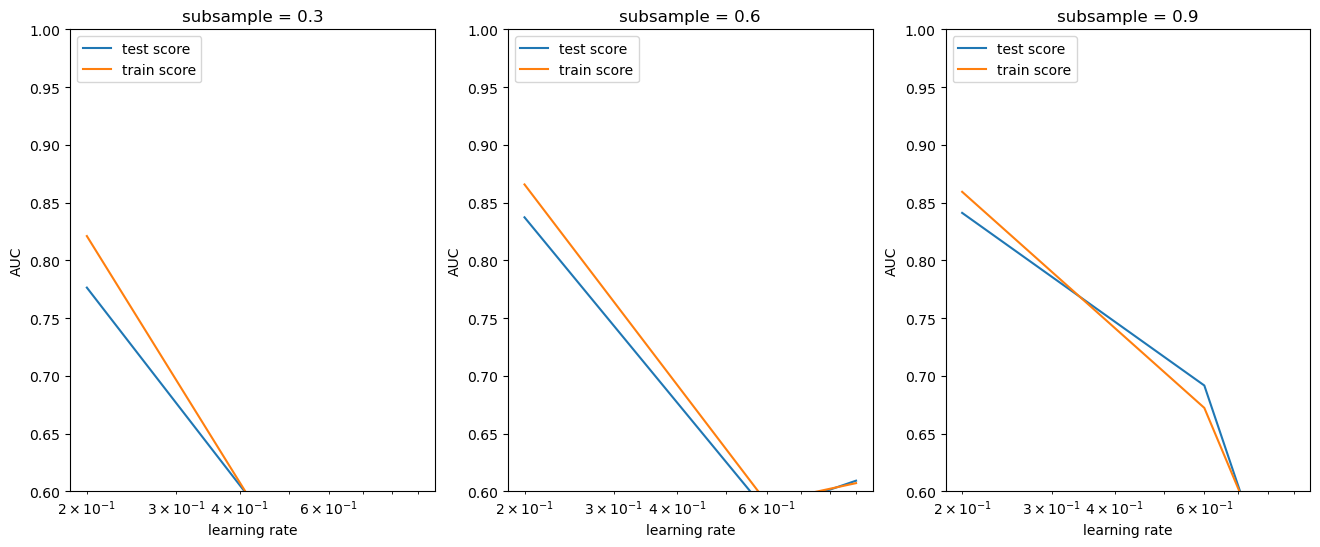

In [51]:
plt.figure(figsize=(16,6))

for n,subsample in enumerate(param_grid['subsample']):
    plt.subplot(1,len(param_grid['subsample']),n+1)
    df = cv_results[cv_results['param_subsample']==subsample]
    
    plt.plot(df['param_learning_rate'],df['mean_test_score'])
    plt.plot(df['param_learning_rate'],df['mean_train_score'])
    
    plt.xlabel('learning rate')
    plt.ylabel('AUC')
    plt.title(f'subsample = {subsample}')
    plt.ylim([0.6,1])
    plt.legend(['test score','train score'],loc='upper left')
    plt.xscale('log')

In [52]:
GBC.fit(x_train,y_train)

predictions = GBC.predict_proba(x_test)

predictions[:10]

array([[9.99759635e-01, 2.40365249e-04],
       [9.99683461e-01, 3.16539468e-04],
       [9.99385527e-01, 6.14472923e-04],
       [9.99790280e-01, 2.09720179e-04],
       [9.99189954e-01, 8.10045513e-04],
       [9.99824758e-01, 1.75242409e-04],
       [9.99618179e-01, 3.81820940e-04],
       [9.99712348e-01, 2.87651814e-04],
       [9.99781825e-01, 2.18175325e-04],
       [9.98997601e-01, 1.00239939e-03]])

In [53]:
metrics.roc_auc_score(y_test,predictions[:,1])

0.9599148083187171

In [54]:
model = XGBClassifier(random_state=1)

model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [55]:
y_pred = model.predict_proba(x_test)

y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [56]:
metrics.roc_auc_score(y_test,y_pred[:,1])*100

96.06303070798185

In [57]:
folds = 3

param_grid = {'learning_rate':[0.2,0.6],
             'subsample': [0.3,0.6,0.9]
             }

xgb_model = XGBClassifier(max_depth=2,n_estimators=200,random_state=1)

model_cv = GridSearchCV(estimator=xgb_model,
                       param_grid=param_grid,
                       scoring='roc_auc',
                       cv=folds,
                       verbose=1,
                       return_train_score=True)



In [58]:
model_cv.fit(x_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...t=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [59]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.407204,0.154755,0.032341,0.001248,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.918476,0.966470,0.959373,0.948106,0.021151,3,0.990313,0.984284,0.993700,0.989432,0.003894
1,2.623921,0.084279,0.035675,0.003300,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.933275,0.978913,0.950468,0.954218,0.018819,1,0.993116,0.987288,0.994242,0.991549,0.003047
2,2.721277,0.008958,0.035342,0.006130,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924940,0.973210,0.950138,0.949429,0.019712,2,0.993739,0.989940,0.994238,0.992639,0.001919
3,2.297351,0.073090,0.034341,0.004029,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.903041,0.948284,0.920718,0.924014,0.018617,6,0.997775,0.995323,0.996475,0.996525,0.001002
4,2.664100,0.116412,0.035341,0.004191,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.909776,0.970954,0.944572,0.941768,0.025054,4,0.999613,0.998645,0.999649,0.999303,0.000465
5,2.766286,0.071198,0.036342,0.003301,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.900652,0.967076,0.950202,0.939310,0.028190,5,0.999575,0.999293,0.999550,0.999473,0.000127


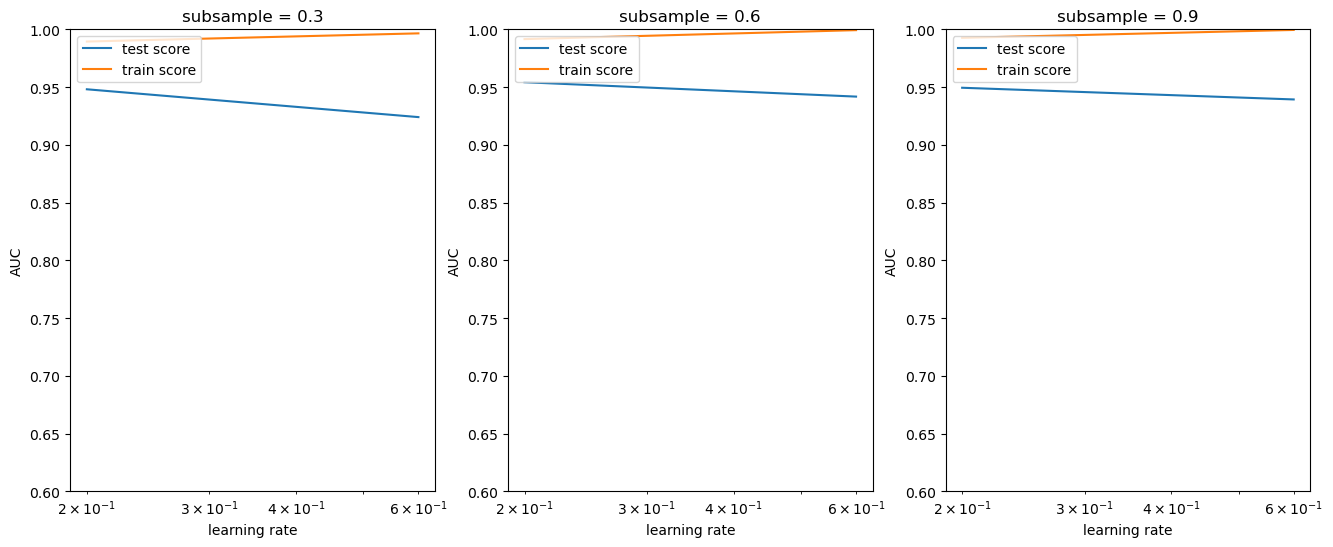

In [60]:
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2,0.6],
             'subsample': [0.3,0.6,0.9]}

for n, subsample in enumerate(param_grid['subsample']):
    plt.subplot(1,len(param_grid['subsample']),n+1)
    df = cv_results[cv_results['param_subsample']==subsample]
    
    plt.plot(df['param_learning_rate'],df['mean_test_score'])
    plt.plot(df['param_learning_rate'],df['mean_train_score'])
    plt.xlabel('learning rate')
    plt.ylabel('AUC')
    plt.title(f'subsample = {subsample}')
    plt.ylim(0.6,1)
    plt.legend(['test score','train score'],loc='upper left')
    plt.xscale('log')

In [61]:
params = {'learning_rate': 0.2,
          'max_depth': 2,
          'n_estimators':200,
          'subsample':0.6,
          'objective':'binary:logistic',
          'random_state':1
    
}

XGB = XGBClassifier(params=params)

XGB.fit(x_train,y_train)

[14:48:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'random_state': 1,
                      'subsample': 0.6},
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [62]:
y_pred = XGB.predict_proba(x_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [63]:
metrics.roc_auc_score(y_test,y_pred[:,1])

0.9606303070798186

In [64]:
importance = dict(zip(x_train.columns, model.feature_importances_))
importance

{'ip': 0.047281995,
 'app': 0.17046945,
 'device': 0.22968191,
 'os': 0.08196739,
 'channel': 0.15076274,
 'day_of_week': 0.05127023,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.04917619,
 'ip_count': 0.072104864,
 'ip_day_hour': 0.042323995,
 'ip_hour_channel': 0.0,
 'ip_hour_os': 0.040770125,
 'ip_hour_app': 0.026437322,
 'ip_hour_device': 0.037753765}

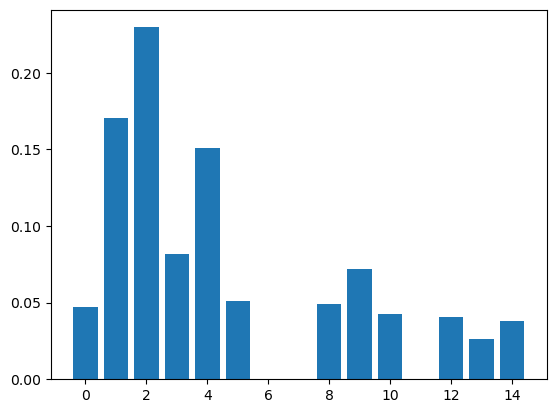

In [65]:
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
plt.show()

In [68]:
from lightgbm import LGBMClassifier

In [69]:
LGB  = LGBMClassifier(random_state=1)

LGB.fit(x_train,y_train)

LGBMClassifier(random_state=1)

In [70]:
y_pred = LGB.predict_proba(x_test)
y_pred[:10]

array([[9.99997609e-01, 2.39140823e-06],
       [9.99985124e-01, 1.48759511e-05],
       [9.99998668e-01, 1.33213465e-06],
       [9.99985600e-01, 1.43999851e-05],
       [9.99935485e-01, 6.45154560e-05],
       [9.99994911e-01, 5.08854217e-06],
       [9.99995125e-01, 4.87501640e-06],
       [1.00000000e+00, 4.45827227e-12],
       [1.00000000e+00, 0.00000000e+00],
       [9.99965187e-01, 3.48131849e-05]])

In [71]:
metrics.roc_auc_score(y_test,y_pred[:,1])

0.8462212199671483

In [72]:
#params = {'learning_rate': 0.2,
#          'max_depth': 2, 
#          'n_estimators':200,
#          'subsample':0.6,
#         'objective':'binary:logistic',
#         'random_state':1}

LGB = LGBMClassifier(learning_rate=0.2,
                   max_depth=2,
                    n_estimators=200,
                    subsample=0.6,
                    random_state=1)

LGB.fit(x_train,y_train)

LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, random_state=1,
               subsample=0.6)

In [74]:
y_pred = LGB.predict_proba(x_test)

In [75]:
metrics.roc_auc_score(y_test,y_pred[:,1])

0.9179091845541356

In [78]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=1)

cat.fit(x_train,y_train)

Learning rate set to 0.06692
0:	learn: 0.5107317	total: 161ms	remaining: 2m 40s
1:	learn: 0.3708259	total: 184ms	remaining: 1m 31s
2:	learn: 0.2729145	total: 207ms	remaining: 1m 8s
3:	learn: 0.2003276	total: 234ms	remaining: 58.4s
4:	learn: 0.1525567	total: 257ms	remaining: 51.1s
5:	learn: 0.1183004	total: 278ms	remaining: 46.1s
6:	learn: 0.0926960	total: 302ms	remaining: 42.9s
7:	learn: 0.0741231	total: 325ms	remaining: 40.3s
8:	learn: 0.0608923	total: 350ms	remaining: 38.5s
9:	learn: 0.0465871	total: 372ms	remaining: 36.8s
10:	learn: 0.0387759	total: 393ms	remaining: 35.3s
11:	learn: 0.0329881	total: 417ms	remaining: 34.3s
12:	learn: 0.0289557	total: 443ms	remaining: 33.6s
13:	learn: 0.0251152	total: 469ms	remaining: 33s
14:	learn: 0.0217928	total: 491ms	remaining: 32.2s
15:	learn: 0.0196789	total: 513ms	remaining: 31.6s
16:	learn: 0.0177198	total: 536ms	remaining: 31s
17:	learn: 0.0161780	total: 559ms	remaining: 30.5s
18:	learn: 0.0150968	total: 583ms	remaining: 30.1s
19:	learn: 0.0

160:	learn: 0.0054373	total: 3.85s	remaining: 20.1s
161:	learn: 0.0054275	total: 3.87s	remaining: 20s
162:	learn: 0.0053993	total: 3.9s	remaining: 20s
163:	learn: 0.0053939	total: 3.92s	remaining: 20s
164:	learn: 0.0053756	total: 3.94s	remaining: 19.9s
165:	learn: 0.0053650	total: 3.96s	remaining: 19.9s
166:	learn: 0.0053604	total: 3.97s	remaining: 19.8s
167:	learn: 0.0053533	total: 3.99s	remaining: 19.8s
168:	learn: 0.0053489	total: 4.01s	remaining: 19.7s
169:	learn: 0.0053265	total: 4.03s	remaining: 19.7s
170:	learn: 0.0053160	total: 4.04s	remaining: 19.6s
171:	learn: 0.0053128	total: 4.07s	remaining: 19.6s
172:	learn: 0.0053005	total: 4.09s	remaining: 19.5s
173:	learn: 0.0052964	total: 4.11s	remaining: 19.5s
174:	learn: 0.0052910	total: 4.13s	remaining: 19.4s
175:	learn: 0.0052889	total: 4.15s	remaining: 19.4s
176:	learn: 0.0052783	total: 4.17s	remaining: 19.4s
177:	learn: 0.0052752	total: 4.19s	remaining: 19.4s
178:	learn: 0.0052715	total: 4.21s	remaining: 19.3s
179:	learn: 0.00525

323:	learn: 0.0041413	total: 7.08s	remaining: 14.8s
324:	learn: 0.0041400	total: 7.1s	remaining: 14.7s
325:	learn: 0.0041302	total: 7.12s	remaining: 14.7s
326:	learn: 0.0041286	total: 7.14s	remaining: 14.7s
327:	learn: 0.0041247	total: 7.16s	remaining: 14.7s
328:	learn: 0.0041188	total: 7.17s	remaining: 14.6s
329:	learn: 0.0041125	total: 7.2s	remaining: 14.6s
330:	learn: 0.0041034	total: 7.22s	remaining: 14.6s
331:	learn: 0.0040887	total: 7.24s	remaining: 14.6s
332:	learn: 0.0040859	total: 7.26s	remaining: 14.5s
333:	learn: 0.0040742	total: 7.28s	remaining: 14.5s
334:	learn: 0.0040684	total: 7.3s	remaining: 14.5s
335:	learn: 0.0040642	total: 7.32s	remaining: 14.5s
336:	learn: 0.0040618	total: 7.33s	remaining: 14.4s
337:	learn: 0.0040581	total: 7.36s	remaining: 14.4s
338:	learn: 0.0040548	total: 7.37s	remaining: 14.4s
339:	learn: 0.0040391	total: 7.39s	remaining: 14.4s
340:	learn: 0.0040309	total: 7.41s	remaining: 14.3s
341:	learn: 0.0040253	total: 7.43s	remaining: 14.3s
342:	learn: 0.0

484:	learn: 0.0032787	total: 10.3s	remaining: 11s
485:	learn: 0.0032673	total: 10.3s	remaining: 10.9s
486:	learn: 0.0032661	total: 10.4s	remaining: 10.9s
487:	learn: 0.0032638	total: 10.4s	remaining: 10.9s
488:	learn: 0.0032608	total: 10.4s	remaining: 10.9s
489:	learn: 0.0032516	total: 10.4s	remaining: 10.8s
490:	learn: 0.0032495	total: 10.4s	remaining: 10.8s
491:	learn: 0.0032467	total: 10.5s	remaining: 10.8s
492:	learn: 0.0032448	total: 10.5s	remaining: 10.8s
493:	learn: 0.0032413	total: 10.5s	remaining: 10.8s
494:	learn: 0.0032401	total: 10.5s	remaining: 10.7s
495:	learn: 0.0032394	total: 10.5s	remaining: 10.7s
496:	learn: 0.0032192	total: 10.6s	remaining: 10.7s
497:	learn: 0.0032155	total: 10.6s	remaining: 10.7s
498:	learn: 0.0032144	total: 10.6s	remaining: 10.6s
499:	learn: 0.0032083	total: 10.6s	remaining: 10.6s
500:	learn: 0.0032038	total: 10.6s	remaining: 10.6s
501:	learn: 0.0032012	total: 10.6s	remaining: 10.6s
502:	learn: 0.0031970	total: 10.7s	remaining: 10.5s
503:	learn: 0.

652:	learn: 0.0025589	total: 13.5s	remaining: 7.2s
653:	learn: 0.0025581	total: 13.6s	remaining: 7.17s
654:	learn: 0.0025578	total: 13.6s	remaining: 7.15s
655:	learn: 0.0025538	total: 13.6s	remaining: 7.13s
656:	learn: 0.0025496	total: 13.6s	remaining: 7.11s
657:	learn: 0.0025466	total: 13.6s	remaining: 7.09s
658:	learn: 0.0025447	total: 13.7s	remaining: 7.06s
659:	learn: 0.0025408	total: 13.7s	remaining: 7.04s
660:	learn: 0.0025339	total: 13.7s	remaining: 7.02s
661:	learn: 0.0025306	total: 13.7s	remaining: 7s
662:	learn: 0.0025295	total: 13.7s	remaining: 6.97s
663:	learn: 0.0025277	total: 13.7s	remaining: 6.95s
664:	learn: 0.0025241	total: 13.8s	remaining: 6.93s
665:	learn: 0.0025238	total: 13.8s	remaining: 6.91s
666:	learn: 0.0025213	total: 13.8s	remaining: 6.89s
667:	learn: 0.0025197	total: 13.8s	remaining: 6.87s
668:	learn: 0.0025175	total: 13.8s	remaining: 6.84s
669:	learn: 0.0025118	total: 13.8s	remaining: 6.82s
670:	learn: 0.0025077	total: 13.9s	remaining: 6.8s
671:	learn: 0.002

813:	learn: 0.0021230	total: 16.6s	remaining: 3.79s
814:	learn: 0.0021180	total: 16.6s	remaining: 3.77s
815:	learn: 0.0021176	total: 16.6s	remaining: 3.75s
816:	learn: 0.0021156	total: 16.6s	remaining: 3.73s
817:	learn: 0.0021150	total: 16.7s	remaining: 3.71s
818:	learn: 0.0021115	total: 16.7s	remaining: 3.69s
819:	learn: 0.0021092	total: 16.7s	remaining: 3.67s
820:	learn: 0.0021050	total: 16.7s	remaining: 3.65s
821:	learn: 0.0021028	total: 16.7s	remaining: 3.63s
822:	learn: 0.0020979	total: 16.8s	remaining: 3.6s
823:	learn: 0.0020944	total: 16.8s	remaining: 3.58s
824:	learn: 0.0020895	total: 16.8s	remaining: 3.56s
825:	learn: 0.0020891	total: 16.8s	remaining: 3.54s
826:	learn: 0.0020871	total: 16.8s	remaining: 3.52s
827:	learn: 0.0020829	total: 16.9s	remaining: 3.5s
828:	learn: 0.0020825	total: 16.9s	remaining: 3.48s
829:	learn: 0.0020781	total: 16.9s	remaining: 3.46s
830:	learn: 0.0020766	total: 16.9s	remaining: 3.44s
831:	learn: 0.0020718	total: 16.9s	remaining: 3.42s
832:	learn: 0.

980:	learn: 0.0017578	total: 19.8s	remaining: 383ms
981:	learn: 0.0017545	total: 19.8s	remaining: 363ms
982:	learn: 0.0017533	total: 19.8s	remaining: 343ms
983:	learn: 0.0017498	total: 19.9s	remaining: 323ms
984:	learn: 0.0017473	total: 19.9s	remaining: 303ms
985:	learn: 0.0017466	total: 19.9s	remaining: 282ms
986:	learn: 0.0017457	total: 19.9s	remaining: 262ms
987:	learn: 0.0017446	total: 19.9s	remaining: 242ms
988:	learn: 0.0017444	total: 19.9s	remaining: 222ms
989:	learn: 0.0017435	total: 20s	remaining: 202ms
990:	learn: 0.0017426	total: 20s	remaining: 181ms
991:	learn: 0.0017418	total: 20s	remaining: 161ms
992:	learn: 0.0017412	total: 20s	remaining: 141ms
993:	learn: 0.0017388	total: 20s	remaining: 121ms
994:	learn: 0.0017381	total: 20.1s	remaining: 101ms
995:	learn: 0.0017331	total: 20.1s	remaining: 80.6ms
996:	learn: 0.0017268	total: 20.1s	remaining: 60.4ms
997:	learn: 0.0017249	total: 20.1s	remaining: 40.3ms
998:	learn: 0.0017231	total: 20.1s	remaining: 20.1ms
999:	learn: 0.0017

In [79]:
cat = CatBoostClassifier(learning_rate=0.2,
                         max_depth=2,
                         n_estimators=200,
                         subsample=0.6,
                         random_state=1
                        )

cat.fit(x_train,y_train)

0:	learn: 0.2613732	total: 17.8ms	remaining: 3.55s
1:	learn: 0.1107276	total: 33.7ms	remaining: 3.33s
2:	learn: 0.0567445	total: 47.8ms	remaining: 3.14s
3:	learn: 0.0348247	total: 63ms	remaining: 3.09s
4:	learn: 0.0248351	total: 78.8ms	remaining: 3.07s
5:	learn: 0.0195207	total: 95.2ms	remaining: 3.08s
6:	learn: 0.0164363	total: 111ms	remaining: 3.07s
7:	learn: 0.0144478	total: 129ms	remaining: 3.1s
8:	learn: 0.0137618	total: 144ms	remaining: 3.05s
9:	learn: 0.0130991	total: 158ms	remaining: 2.99s
10:	learn: 0.0127022	total: 172ms	remaining: 2.96s
11:	learn: 0.0125861	total: 189ms	remaining: 2.96s
12:	learn: 0.0123631	total: 206ms	remaining: 2.96s
13:	learn: 0.0122499	total: 223ms	remaining: 2.97s
14:	learn: 0.0119361	total: 238ms	remaining: 2.93s
15:	learn: 0.0118870	total: 254ms	remaining: 2.92s
16:	learn: 0.0116837	total: 268ms	remaining: 2.88s
17:	learn: 0.0115112	total: 284ms	remaining: 2.87s
18:	learn: 0.0114073	total: 298ms	remaining: 2.84s
19:	learn: 0.0112929	total: 315ms	rema

177:	learn: 0.0068006	total: 2.76s	remaining: 341ms
178:	learn: 0.0067967	total: 2.77s	remaining: 325ms
179:	learn: 0.0067916	total: 2.78s	remaining: 309ms
180:	learn: 0.0067862	total: 2.79s	remaining: 293ms
181:	learn: 0.0067648	total: 2.8s	remaining: 277ms
182:	learn: 0.0067552	total: 2.81s	remaining: 261ms
183:	learn: 0.0067534	total: 2.82s	remaining: 246ms
184:	learn: 0.0067501	total: 2.84s	remaining: 230ms
185:	learn: 0.0067484	total: 2.85s	remaining: 214ms
186:	learn: 0.0067293	total: 2.86s	remaining: 199ms
187:	learn: 0.0067282	total: 2.87s	remaining: 183ms
188:	learn: 0.0067240	total: 2.88s	remaining: 168ms
189:	learn: 0.0067231	total: 2.9s	remaining: 152ms
190:	learn: 0.0067163	total: 2.91s	remaining: 137ms
191:	learn: 0.0067110	total: 2.92s	remaining: 122ms
192:	learn: 0.0067064	total: 2.93s	remaining: 106ms
193:	learn: 0.0067051	total: 2.94s	remaining: 91.1ms
194:	learn: 0.0067019	total: 2.96s	remaining: 75.8ms
195:	learn: 0.0066833	total: 2.97s	remaining: 60.6ms
196:	learn:

In [80]:
y_pred = cat.predict_proba(x_test)
metrics.roc_auc_score(y_test,y_pred[:,1])

0.962935493749826